# Онлайн алгоритмы в задаче формирования портфеля ценных бумаг
Евкарпиев Михаил, Владислав Сергеев, Янковский Вадим

## Постановка задачи

В задаче формирования портфеля ценных бумаг допустимыми решениями являются всевозможные распределения состояния, имеющегося у игрока, т.е. элементы стандартного симплекса:

$$
\Delta_d = \left\{
x \in \mathbb{R}^d
:\;
\sum_{i = 1}^d x_i = 1,
\;
x_i \geq 0
\right\}.
$$

Противник (природа) независимо выбирает рыночную доходность активов,
т.е. вектор $r_t \in \mathbb{R}_+^d$,
у которого $i$-ая компонента определяется формулой

$$
[r_t]_i = \frac{\text{цена единицы $i$-го актива в момент } t + 1}{\text{цена единицы $i$-го актива в момент } t}.
$$

*Цель игрока* — максимизировать свое состояние по проишествии $T$ раундов, которая эквивалентна максимизации величины

$$
\sum_{t=1}^T \log r_t^\top x_t,
$$

которую будем называть *логарифмическим приростом* портфеля ценных бумаг к моменту времени $T$.

Регрет алгоритма $\mathcal{A}$ к раунду $T$ определяется формулой

$$
\mathrm{regret}_T(\mathcal{A})
=
\sum_{t=1}^T f_t(x_t)
-
\min_{x \in \Delta_d}
\sum_{t = 1}^T f_t(x),
$$

где $f_t(x) = -\log r_t^\top x$.

В этом задании вам предстоит реализовать алгоритмического инвестора на основе онлайн градиентного спуска, принимающего решения о перераспределении имеющихся средств между акциями российского фондового рынка:
- в момент времени $t$ алгоритм должен предложить распределение средств между активами $x_t$;
- после этого алгоритму открывается вектор рыночных доходностей $r_t$ из истории наблюдений;
- алгоритм должен использовать поступившую информацию для корректировки и принятия решения на следующей итерации.

## Подготовка данных (3 балла)

Загрузите котировки (сформируйте набор данных) акций `RASP`, `GAZP`, `DSKY`, `SBER`, `KMAZ`, `RUAL` c 01.04.2020 по 22.04.2022 с интервалом в один день (раунд игры = день). Выведите таблицу (`pd.DataFrame`), в которой столбцы содержат временные ряды для каждого тикера, а их названия — тикеры. **[1 балл]**

In [1]:
import numpy as np
import pandas as pd
import pandas_datareader.data as web

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib.pyplot as plt

from numpy.typing import ArrayLike

In [2]:
start_date = '2020-04-01'
end_date = '2022-04-01'

tickers = ['RASP', 'GAZP', 'DSKY', 'SBER', 'KMAZ', 'RUAL']

data = pd.DataFrame()
for ticker in tickers:
    webData = web.DataReader(ticker, 'moex', start_date, end_date)['CLOSE']
    print(f"{ticker}: {len(webData)} дней, с {webData.index.min()} по {webData.index.max()}")
    webData.name = ticker
    data[ticker] = webData

RASP: 495 дней, с 2020-04-01 00:00:00 по 2022-04-01 00:00:00
GAZP: 497 дней, с 2020-04-01 00:00:00 по 2022-04-01 00:00:00
DSKY: 497 дней, с 2020-04-01 00:00:00 по 2022-04-01 00:00:00
SBER: 497 дней, с 2020-04-01 00:00:00 по 2022-04-01 00:00:00
KMAZ: 495 дней, с 2020-04-01 00:00:00 по 2022-04-01 00:00:00
RUAL: 496 дней, с 2020-04-01 00:00:00 по 2022-04-01 00:00:00


In [3]:
quotations = pd.DataFrame(data)
quotations
# df.to_excel('my_data.xlsx', index=True)

,RASP,GAZP,DSKY,SBER,KMAZ,RUAL
TRADEDATE,,,,,,
2020-04-01,97.76,180.06,90.12,184.78,51.0,24.755
2020-04-02,99.40,187.04,90.62,186.95,50.9,24.955
2020-04-03,99.10,189.77,94.42,185.64,53.6,24.830
2020-04-06,100.92,191.10,97.80,190.70,54.4,25.755
2020-04-07,98.98,191.22,98.12,197.63,54.8,26.050
...,...,...,...,...,...,...
2022-03-28,349.90,218.60,73.72,125.00,101.5,64.935
2022-03-29,387.80,208.00,73.00,128.77,117.9,63.000
2022-03-30,424.35,216.00,80.98,134.60,111.3,65.475


Визуализируйте поведение всех тикеров на всём горизонте игры. **[1 балл]**

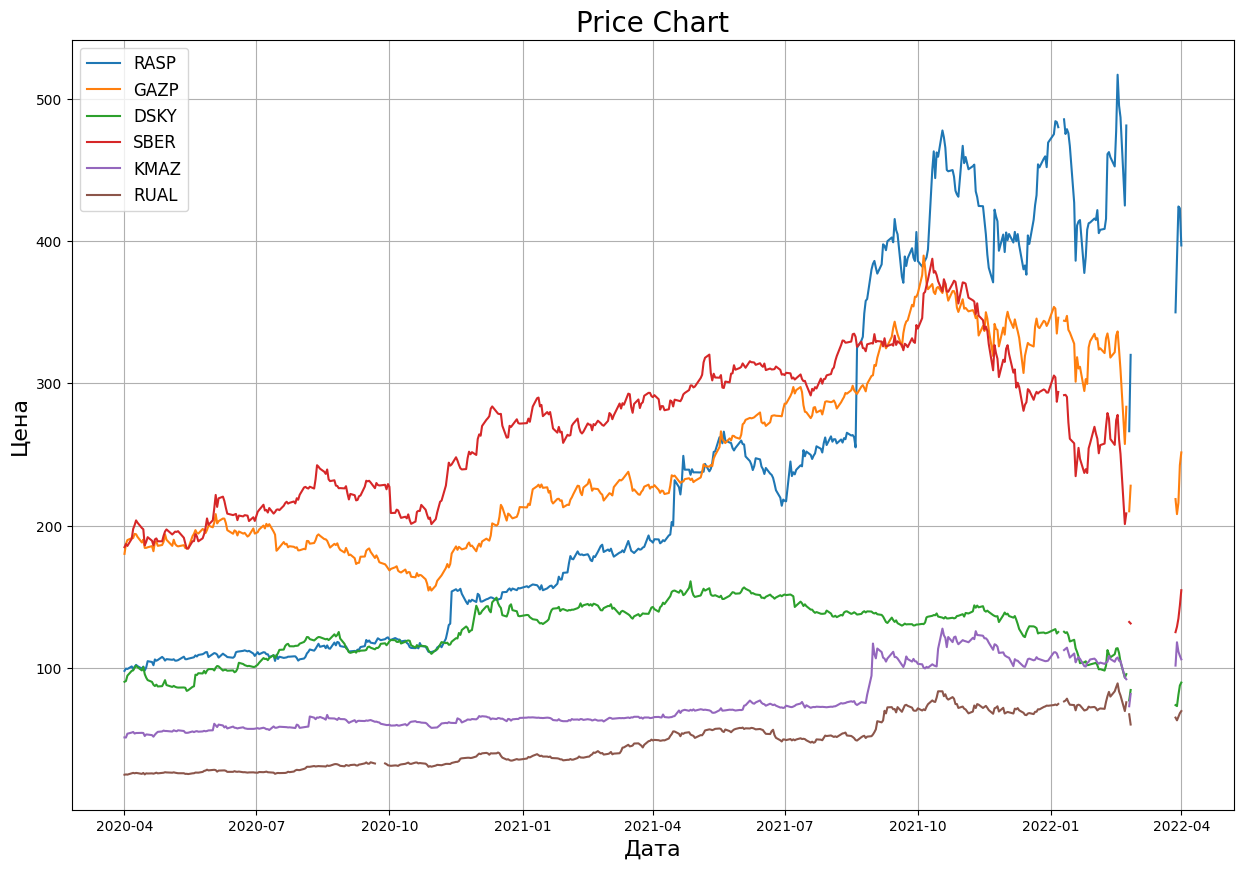

In [4]:
plt.figure(figsize=(15,10))

plt.title('Price Chart', fontsize=20)
plt.xlabel('Дата', fontsize=16)
plt.ylabel('Цена', fontsize=16)
plt.grid(True)

for col in data.columns:
    plt.plot(data.index, data[col], label=col)

plt.legend(loc='best', fontsize=12)
plt.show()

Постройте таблицу (с тем же заголовком), содержащую по столбцам временные ряды *рыночных доходностей* тикеров. **[1 балл]**


In [5]:
yields = (data.shift(-1) / data).dropna()
yields.applymap(lambda x: '{:.4}'.format(x))

,RASP,GAZP,DSKY,SBER,KMAZ,RUAL
TRADEDATE,,,,,,
2020-04-01,1.017,1.039,1.006,1.012,0.998,1.008
2020-04-02,0.997,1.015,1.042,0.993,1.053,0.995
2020-04-03,1.018,1.007,1.036,1.027,1.015,1.037
2020-04-06,0.9808,1.001,1.003,1.036,1.007,1.011
2020-04-07,1.017,1.015,1.019,1.013,0.9799,0.9885
...,...,...,...,...,...,...
2022-02-24,1.202,1.086,1.095,0.992,1.118,0.893
2022-03-28,1.108,0.9515,0.9902,1.03,1.162,0.9702
2022-03-29,1.094,1.038,1.109,1.045,0.944,1.039


## Онлайн градиентный спуск (8 баллов)

Приведите выражение для градиента функции $f_t(x)$ и запишите явную формулу для итерации OGD. **[1 балл]**

*Место для выкладок.*

Градиент функции $f_t(x)$:

$$∇ f_t(x) = \frac{r_t}{r_t^\top x}$$

Итерация OGD в данном случае выглядит следующим образом:
​
$$x_{t+1}=\Pi_{D}(x_t - \eta\sum_{t=1}^{t}{∇f_i(x_i)})$$

где $\eta > 0$ - размер шага. Проекция на стандартный симплекс $\Pi_{D}$ заключается в следующем:

$$\Pi_{D}(y)=arg\min\limits_{x\in△_d}\left||{x-y}\right||_2$$

В случае стандартного симплекса формула проекции имеет следующий вид:

$$[\Pi_{D}(y)]_i = \max{\{y_i;0\}}$$

$$[\Pi_{D}(y)]_d=1-\sum_{i=1}^{d-1}{[\Pi_{D}(y)]_i}$$

$$y_{t+1} = x_{t} - \alpha∇f_{t}(x_{t}) $$
$$x_{t+1} = \Pi_{D}(y_{t+1}) $$

Реализуйте инвестора, принимающего решение на основе итераций онлайн градиентного спуска. **[4 балла]**

Используйте готовую функцию `simplex_projection`, проектирующую входной вектор на стандартный симплекс.

In [6]:
def _unsafe_simplex_projection(s: ArrayLike, norm_constraint: float) -> ArrayLike:
    """Находит проекцию на симплекс."""
    u = np.sort(s)[::-1]
    cssv = np.cumsum(u)
    rho = np.nonzero(u * np.arange(1, len(u) + 1) > (cssv - norm_constraint))[0][-1]
    theta = (cssv[rho] - norm_constraint) / (rho + 1.0)
    return np.maximum(s - theta, 0)


def simplex_projection(s: ArrayLike):
    """Возвращает проекцию на единичный симплекс."""
    return s if np.sum(s) == 1 else _unsafe_simplex_projection(s, 1.0)

In [7]:
# реализация онлайн градиентного спуска
import copy
class OnlineGradientDescent:
    def __init__(self, eta: float):
        self.eta = eta
        self.weights = None
        
    def get_action(self, r_t: ArrayLike) -> ArrayLike: # одна итерация
        if self.weights is None:
            self.weights = np.ones(len(r_t)) / len(r_t)  # начальное распределение
        # print(r_t) 
        # находим градиент
        grad = -r_t / np.dot(self.weights, r_t)
        # print(grad)

        # обновляем распределение
        self.weights -= self.eta * grad
        self.weights = simplex_projection(self.weights)
        # print(self.weights)
        return copy.deepcopy(self.weights)

### Запуск OGD

Как будете выбирать шаг при запуске OGD? Приведите исчерпывающее объяснение и мотивацию. **[1 балл]**

*Место для выкладок.*

Шаг $\eta_t$ в OGD выбирается обычно по правилу $\eta_t = \frac{\alpha}{\sqrt{t}}$, где $\alpha$ - некоторая постоянная, выбираемая так, чтобы гарантировать сходимость алгоритма к оптимальному решению.

Такой выбор шага является эмпирическим правилом, основанным на теоретическом анализе скорости сходимости метода OGD. В частности, если функция $f_t(x)$ является сильно выпуклой, то можно показать, что ошибка OGD будет убывать как $\mathcal{O}(\frac{1}{\sqrt{t}})$.

С другой стороны, выбор шага необходимо сбалансировать между скоростью сходимости и вычислительной эффективностью. Более маленькие значения $\alpha$ приводят к более медленной сходимости, но могут уменьшить шум в выборке и сделать более устойчивым к нарушениям модели, в то время как большие значения могут привести к переобучению или неустойчивости алгоритма.

Обычно, начальное значение параметра $\alpha$ выбирается эмпирически и далее может быть корректировано на основе анализа сходимости алгоритма на конкретных данных.

Начиная с равномерного распределения состояния между активами, запустите OGD на всём горизонте игры. Визуализируйте динамику логарифмического прироста портфеля ценных бумаг за весь период для OGD и инвестора, зафиксировавшего своё (произвольное) распределение в начале игры. **[2 балла]**

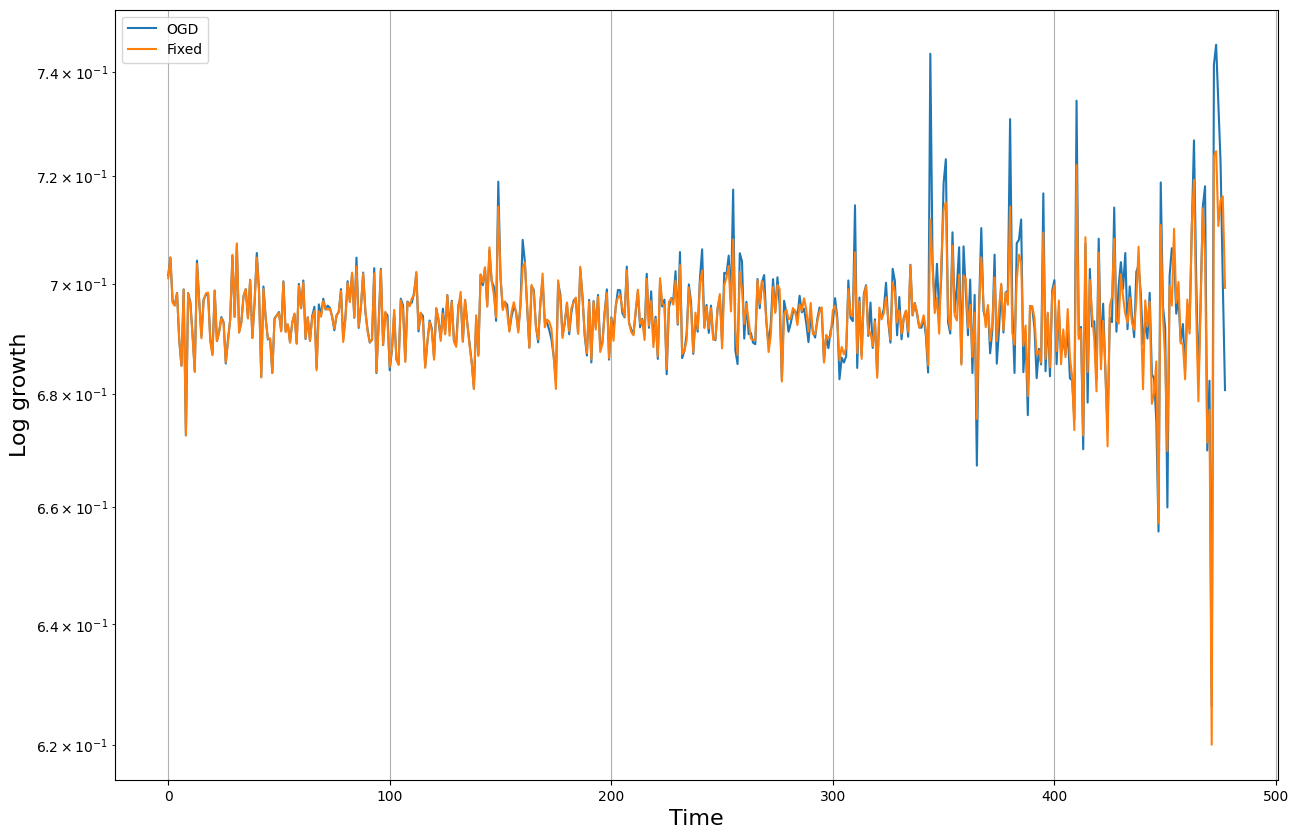

In [8]:
# расчет весов
import copy
OGD = OnlineGradientDescent(eta=0.4)
all_weights = []
for i in range(len(yields)):
    all_weights.append(OGD.get_action(pd.to_numeric(yields.iloc[i])))

# расчет доходности
values = np.ones(len(all_weights))
values[0] = 1 + all_weights[0].dot(pd.to_numeric(yields.iloc[0]))

for i in range(1, len(all_weights)):
    values[i] = values[i-1] * (1 + all_weights[i].dot(pd.to_numeric(yields.iloc[i])))

# расчет логарифмического прироста
log_growth = np.log(values)
log_growth_new = np.diff(log_growth)

# зафиксированное распределение в начале игры
fixed_weights = np.ones(6)/6

fixed_log_growth = np.log(np.cumprod(1 + fixed_weights.dot(yields.values.T)))
fixed_log_growth_new = np.diff(fixed_log_growth)

plt.figure(figsize=(15,10))
plt.semilogy(log_growth_new, label='OGD')
plt.semilogy(fixed_log_growth_new, label='Fixed')
plt.xlabel('Time', fontsize=16)
plt.ylabel('Log growth', fontsize=16)
plt.legend()
plt.grid(True)
plt.show()


## Дополнительное задание (4 балла)

Реализуйте любой подходящий канонический онлайн алгоритм из курса или даже их композицию. Визуализируйте динамику логарифмического прироста портфеля ценных бумаг за весь период для OGD и инвестора, принимающего решения на основе выбранного алгоритма. Сравните итоговые распределения, полученные с помощью этих алгоритмов, и попробуйте сделать выводы.

Для выполнения данного задания был выбран метод стохастического градиентного спуска. Это итерационный метод для оптимизации целевой функции. Стохастический градиентный спуск - это радикальное упрощение обычного градиентного спуска, которое преодолевает некоторые из его трудностей. Каждая итерация SGD вычисляет градиент на основе одного случайно выбранного раздела набора данных,  вместо использования всей части наблюдений. Эта модификация GD может значительно сократить время вычисления.

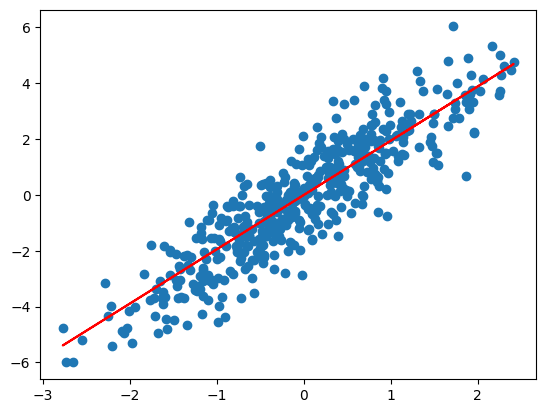

In [11]:
class StochasticGradientDescent:
    def __init__(self, eta: float, n_iterations: int):
        self.eta = eta
        self.n_iterations = n_iterations
        self.weights = None

    def fit(self, X: np.ndarray, y: np.ndarray):
        n_samples, n_features = X.shape

        if self.weights is None:
            self.weights = np.zeros(n_features)

        for _ in range(self.n_iterations):
            for i in range(n_samples):
                # выбираем случайный пример
                random_index = np.random.randint(n_samples)
                xi = X[random_index]
                yi = y[random_index]

                # вычисляем градиент
                grad = 2 * xi.T.dot(xi.dot(self.weights) - yi)

                # обновляем веса
                self.weights -= self.eta * grad

    def predict(self, X: np.ndarray):
        return X.dot(self.weights)

# Пример использования
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(0)
n_samples = len(yields)
X = np.random.randn(n_samples, 1)
y = 2 * X.squeeze() + np.random.randn(n_samples)

# Обучаем модель
sgd = StochasticGradientDescent(eta=0.01, n_iterations=100)
sgd.fit(X, y)

# Визуализируем результаты
plt.scatter(X.squeeze(), y)
plt.plot(X.squeeze(), sgd.predict(X), c='r')
plt.show()